# Data Load

In [1]:
import pandas as pd

df = pd.read_csv('../NLME.csv', low_memory=False)
unique_labels = df['label'].unique()
print("Unique labels:", unique_labels)
label_counts = df['label'].value_counts()
print("Value counts:\n", label_counts)

df2 = pd.read_csv('../parsed_events (20).csv', low_memory=False)

unique_labels = df2['label'].unique()
print("Unique labels:", unique_labels)
label_counts = df2['label'].value_counts()
print("Value counts:\n", label_counts)

Unique labels: [0 1]
Value counts:
 label
0    53802
1    17215
Name: count, dtype: int64
Unique labels: [0 1]
Value counts:
 label
0    602450
1    162061
Name: count, dtype: int64


# Data Preprocess

In [2]:
df2.rename(columns={
    'target_file_name': 'TargetFilename',
    'event_id': 'EventID',
    'target_process_guid': 'TargetProcessGuid',
    'event_type': 'EventType',
    'target_image': 'TargetImage',
    'previous_creation_utc_time': 'PreviousCreationUtcTime',
    'destination_host_name': 'DestinationHostname',
    'company': 'Company',
    'description': 'Description',
    'product': 'Product',
    'integrity_level': 'IntegrityLevel',
    'creation_utc_time': 'CreationUtcTime',
    'start_function': 'StartFunction',
    'parent_process_id': 'ParentProcessGuid',
    'user': 'User',
    'logon_id': 'LogonId',
    'parent_process_id': 'ParentProcessId',
    'terminal_session_id': 'TerminalSessionId',
    'rule_name': 'RuleName',
    'target_object': 'TargetObject',
    'parent_process_guid': 'ParentProcessGuid'
    }, inplace=True)

In [3]:
important_columns = [
    'TargetFilename', 
    'EventID', 
    'TargetProcessGuid', 
    # 'EventType',
    'TargetImage', 
    # 'PreviousCreationUtcTime', 
    # 'DestinationHostname', 
    'Company', 
    'Description',
    'Product', 
    'IntegrityLevel', 
    # 'CreationUtcTime', 
    # 'StartFunction', 
    'ParentProcessGuid', 
    'User',
    'LogonId', 
    'ParentProcessId', 
    # 'TerminalSessionId', 
    # 'RuleName', 
    # 'TargetObject', 
    'label'
]

selected_df = df[important_columns]
selected_df2 = df2[important_columns]

## Data Split

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

def clean_and_encode(df):
    df = df.replace('-', np.nan)
    df = df.dropna(axis=1, how='all').drop_duplicates()
    le = LabelEncoder()
    filtered = []
    for col in df.columns:
        if col == 'label':
            continue
        if df[col].nunique() <= 25 and col != 'label':
            filtered.append(col)
            mask = df[col].isnull()
            df.loc[mask, col] = -1
            df.loc[~mask, col] = le.fit_transform(df[col][~mask])
        else:
            if df[col].dtype == "object":
                df[col] = df[col].str.len()
            df[col] = df[col].fillna(-1)
    return df, filtered

def preprocess_data_3(df, df2):
    df['label'] = df['label'].replace({1: -1, 0: 1})
    df2['label'] = df2['label'].replace({1: -1, 0: 1})
    df, filteredColumn = clean_and_encode(df)
    df2, _ = clean_and_encode(df2)
    
    benign_df = df[df['label'] == 1]
    malware_df = df[df['label'] == -1]
    train_df = benign_df.iloc[malware_df.shape[0]:]
    test_df = pd.concat([benign_df.iloc[:malware_df.shape[0]], malware_df])

    benign_df2 = df2[df2['label'] == 1]
    malware_df2 = df2[df2['label'] == -1]
    
    print(filteredColumn)

    train_means = benign_df[filteredColumn].mean()
    test_means = benign_df2[filteredColumn].mean()

    abs_diff = (train_means - test_means).abs()
    df_diff = pd.DataFrame({
        "Train means": train_means,
        "Test means": test_means,
        "Diff": abs_diff
    }).sort_values(by="Diff", ascending=False)

    plt.figure(figsize=(12, 6))
    sns.lineplot(x=range(len(filteredColumn)), y=train_means.values, label="Train Benign")
    sns.lineplot(x=range(len(filteredColumn)), y=test_means.values, label="Test Benign")
    plt.xticks(range(len(filteredColumn)), filteredColumn, rotation=90)
    plt.title("Feature Distribution Shift (Benign)")
    plt.tight_layout()
    plt.show()

    benign_shuffled = benign_df2.sample(frac=1, random_state=42).reset_index(drop=True)
    malware_shuffled = malware_df2.sample(frac=1, random_state=123).reset_index(drop=True)  # Different seed
    
    min_size = min(len(benign_shuffled), len(malware_shuffled))
    benign_for_test = benign_shuffled.iloc[:min_size]
    malware_for_test = malware_shuffled.iloc[:min_size]
    
    benign_test_chunks = np.array_split(benign_for_test, 10)
    malware_test_chunks = np.array_split(malware_for_test, 10)
    
    test_df2 = pd.concat([benign_for_test, malware_for_test])
    test_chunks = []
    for i in range(10):
        combined_chunk = pd.concat([benign_test_chunks[i], malware_test_chunks[i]], ignore_index=True)
        combined_chunk = combined_chunk.sample(frac=1, random_state=i*10).reset_index(drop=True)
        test_chunks.append(combined_chunk)
        print(f"Test chunk {i+1}: {len(combined_chunk)} samples, "
              f"benign: {len(combined_chunk[combined_chunk['label']==1])}, "
              f"malware: {len(combined_chunk[combined_chunk['label']==-1])}")
    
    remaining_benign = benign_shuffled.iloc[min_size:] if len(benign_shuffled) > min_size else benign_shuffled
    
    train_chunks = []
    for i in range(10):
        if len(remaining_benign) > 1000:  # If we have enough data
            train_sample = remaining_benign.sample(n=min(len(remaining_benign), 5000), 
                                                 random_state=i*100, 
                                                 replace=False).reset_index(drop=True)
        else:
            train_sample = remaining_benign.sample(n=5000, 
                                                 random_state=i*100, 
                                                 replace=True).reset_index(drop=True)
        
        train_chunks.append(train_sample)
        print(f"Train chunk {i+1}: {len(train_sample)} benign samples")
    
    print("\nVerifying chunk diversity:")
    for i in range(min(5, len(train_chunks)-1)):
        similarity = len(pd.merge(train_chunks[i], train_chunks[i+1], how='inner')) / len(train_chunks[i])
        print(f"Train chunks {i+1} and {i+2} similarity: {similarity:.2%}")
    
    for i in range(min(5, len(test_chunks)-1)):
        similarity = len(pd.merge(test_chunks[i], test_chunks[i+1], how='inner')) / len(test_chunks[i])
        print(f"Test chunks {i+1} and {i+2} similarity: {similarity:.2%}")

    return df, train_df, test_df, df2, train_chunks, test_chunks, remaining_benign, pd.concat([benign_df2.iloc[:min_size], malware_df2.iloc[:min_size]])


/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_50595/3903420739.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].replace({1: -1, 0: 1})
/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_50595/3903420739.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['label'] = df2['label'].replace({1: -1, 0: 1})


['EventID', 'TargetImage', 'IntegrityLevel', 'User']


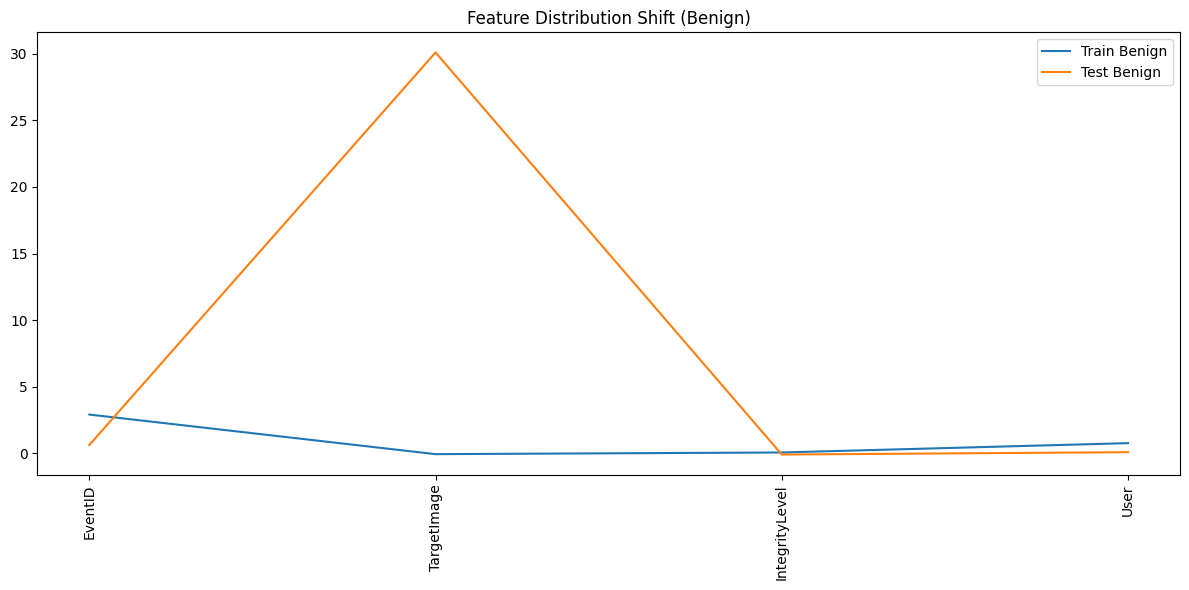

/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Test chunk 1: 13934 samples, benign: 6967, malware: 6967
Test chunk 2: 13932 samples, benign: 6966, malware: 6966
Test chunk 3: 13932 samples, benign: 6966, malware: 6966
Test chunk 4: 13932 samples, benign: 6966, malware: 6966
Test chunk 5: 13932 samples, benign: 6966, malware: 6966
Test chunk 6: 13932 samples, benign: 6966, malware: 6966
Test chunk 7: 13932 samples, benign: 6966, malware: 6966
Test chunk 8: 13932 samples, benign: 6966, malware: 6966
Test chunk 9: 13932 samples, benign: 6966, malware: 6966
Test chunk 10: 13932 samples, benign: 6966, malware: 6966
Train chunk 1: 5000 benign samples
Train chunk 2: 5000 benign samples
Train chunk 3: 5000 benign samples
Train chunk 4: 5000 benign samples
Train chunk 5: 5000 benign samples
Train chunk 6: 5000 benign samples
Train chunk 7: 5000 benign samples
Train chunk 8: 5000 benign samples
Train chunk 9: 5000 benign samples
Train chunk 10: 5000 benign samples

Verifying chunk diversity:
Train chunks 1 and 2 similarity: 267.12%
Train chu

In [5]:
ndf, train_df, test_df, ndf2, train_chunks, test_chunks, train_df2, test_df2 = preprocess_data_3(selected_df, selected_df2)

In [6]:
%load_ext autoreload
%autoreload 2
## import packages
import sys
sys.path.append('../admodels/')
sys.path.append('../moudles/')
sys.path.append('../baselines/')
sys.path.append('../')

from admodels.AE import AE
from admodels.AE import train
from admodels.AE import test
import time

In [7]:
import time
def count_stats(df, outlier=1, label=1):
    tmp = df.apply(lambda x : True if x['outlier'] == outlier and x['label'] == label else False, axis = 1)
    return len(tmp[tmp == True].index)

def test_model(clf, df, thres):
    X_test = df.drop('label', axis=1)
    y_true = df['label'].to_numpy()
    outliers_predicted, rmse_vec = test(clf, thres, X_test) 
    new_df = df.copy()
    new_df['outlier'] = outliers_predicted
    # df.to_csv('y_pred_ae.csv', index=False)
    tp = count_stats(new_df, outlier=-1, label=-1)
    fn = count_stats(new_df, outlier=1, label=-1)
    fp = count_stats(new_df, outlier=-1, label=1)
    tn = count_stats(new_df, outlier=1, label=1)
    # print({f'tp: {tp}'})
    # print({f'fp: {fp}'})
    # print({f'fn: {fn}'})
    # print({f'tn: {tn}'})

    rmse_outliers = rmse_vec[y_true == -1]
    # print(f"➡️ Total true outliers in this test set: {len(rmse_outliers)}")
    # print(f"➡️ Number of those with RMSE > threshold: {np.sum(rmse_outliers > thres)}")
    print(f"Max RMSE among outliers: {np.max(rmse_outliers):.2f}")
    # print(f"➡️ RMSE of first 5 outliers: {rmse_outliers[:5]}")

    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)
    return new_df, recall, precision, f1, tp, fn, fp, tn

# Autoencoders

In [10]:
X_train = train_df.drop('label', axis=1)
X_train = X_train.astype(float)
X_train = X_train.to_numpy()

feature_size = X_train.shape[-1]
AE(feature_size)

model, thres = train(X_train, feature_size)
start = time.time()
_, recall, precision, f1, tp, fn, fp, tn = test_model(model, test_df, thres)
end = time.time()
elapsed = end-start

print('Data training:')
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")
print(f"Elapsed: {elapsed:.4f}")

start = time.time()
_, recall_2, precision_2, f1_2, tp_2, fn_2, fp_2, tn_2 = test_model(model, test_df2, thres)
end = time.time()
elapsed = end-start
print('Data testing:')
print(f"Precision: {precision_2:.3f}, Recall: {recall_2:.3f}, F1-score: {f1_2:.3f}")
print(f"Elapsed: {elapsed:.4f}")

conf_matrix = pd.DataFrame(
    [[tp, fn],
    [fp, tn]],
    columns=['Actual outlier', 'Actual inlier'],
    index=['Predicted outlier', 'Predicted inlier']
)

conf_matrix_2 = pd.DataFrame(
    [[tp_2, fn_2],
    [fp_2, tn_2]],
    columns=['Actual outlier', 'Actual inlier'],
    index=['Predicted outlier', 'Predicted inlier']
)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='grey_r', ax=axs[0])
axs[0].set_title("Confusion Matrix Control")
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='grey_r', ax=axs[1])
axs[1].set_title("Confusion Matrix Treatment")

plt.tight_layout()
plt.savefig("comparison_heatmaps_pca.png")
plt.show()


Epoch 1/100 ----------------
Step 0: Loss = 76377.1171875
Step 10: Loss = 70782.5546875
Step 20: Loss = 66628.578125
epoch:0/100 |Loss: 79225.3125

Epoch 2/100 ----------------
Step 0: Loss = 75723.8984375
Step 10: Loss = 74036.6328125
Step 20: Loss = 71990.5390625
epoch:1/100 |Loss: 72866.1328125

Epoch 3/100 ----------------
Step 0: Loss = 76234.9453125
Step 10: Loss = 68619.84375
Step 20: Loss = 71715.734375
epoch:2/100 |Loss: 67318.53125

Epoch 4/100 ----------------
Step 0: Loss = 63801.78125
Step 10: Loss = 65578.5234375
Step 20: Loss = 75635.9375
epoch:3/100 |Loss: 88165.4609375

Epoch 5/100 ----------------
Step 0: Loss = 66564.6015625
Step 10: Loss = 77291.125
Step 20: Loss = 67797.046875
epoch:4/100 |Loss: 47379.765625

Epoch 6/100 ----------------
Step 0: Loss = 65146.25
Step 10: Loss = 66407.390625
Step 20: Loss = 73314.5703125
epoch:5/100 |Loss: 65816.4140625

Epoch 7/100 ----------------
Step 0: Loss = 64777.79296875
Step 10: Loss = 69866.4453125
Step 20: Loss = 66201.02

/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_95926/2941342948.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


# Retraining

### a. Concat old + new data

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

reference_vec = train_df.mean().values.reshape(1, -1)
similarities = cosine_similarity(train_df2.values, reference_vec).flatten()

k = len(train_df)
top_k_idx = np.argsort(similarities)[-k:]
X2_similar = train_df2.iloc[top_k_idx]

retrain_df = pd.concat([train_df, X2_similar]).sample(frac=1, random_state=42).reset_index(drop=True)
X_train = retrain_df.drop('label',axis=1)


In [10]:
X_train = X_train.astype(float)
X_train = X_train.to_numpy()

feature_size = X_train.shape[-1]
model = AE(feature_size)

model, thres = train(X_train, feature_size)
start = time.time()
_, recall, precision, f1, tp, fn, fp, tn = test_model(model, test_df, thres)
end = time.time()
elapsed = end-start

print('Data training:')
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")
print(f"Elapsed: {elapsed:.4f}")

start = time.time()
_, recall_2, precision_2, f1_2, tp_2, fn_2, fp_2, tn_2 = test_model(model, test_df2, thres)
end = time.time()
elapsed = end-start
print('Data testing:')
print(f"Precision: {precision_2:.3f}, Recall: {recall_2:.3f}, F1-score: {f1_2:.3f}")
print(f"Elapsed: {elapsed:.4f}")

conf_matrix = pd.DataFrame(
    [[tp, fn],
    [fp, tn]],
    columns=['Actual outlier', 'Actual inlier'],
    index=['Predicted outlier', 'Predicted inlier']
)

conf_matrix_2 = pd.DataFrame(
    [[tp_2, fn_2],
    [fp_2, tn_2]],
    columns=['Actual outlier', 'Actual inlier'],
    index=['Predicted outlier', 'Predicted inlier']
)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='grey_r', ax=axs[0])
axs[0].set_title("Confusion Matrix Control")
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='grey_r', ax=axs[1])
axs[1].set_title("Confusion Matrix Treatment")

plt.tight_layout()
plt.savefig("comparison_heatmaps_b_pca.png")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9400 entries, 0 to 70519
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TargetFilename     9400 non-null   float64
 1   EventID            9400 non-null   int64  
 2   TargetProcessGuid  9400 non-null   float64
 3   TargetImage        9400 non-null   object 
 4   Company            9400 non-null   float64
 5   Description        9400 non-null   float64
 6   Product            9400 non-null   float64
 7   IntegrityLevel     9400 non-null   object 
 8   ParentProcessGuid  9400 non-null   float64
 9   User               9400 non-null   object 
 10  LogonId            9400 non-null   float64
 11  ParentProcessId    9400 non-null   float64
 12  label              9400 non-null   int64  
dtypes: float64(8), int64(2), object(3)
memory usage: 1.0+ MB


### b. Full model replacement with new data

In [8]:
X_train = train_df2.drop('label', axis=1)
X_train = X_train.astype(float)
X_train = X_train.to_numpy()

feature_size = X_train.shape[-1]
AE(feature_size)

model, thres = train(X_train, feature_size)

start = time.time()
_, recall_2, precision_2, f1_2, tp, fn, fp, tn = test_model(model, test_df2, thres)
end = time.time()
elapsed = end-start

print('Data testing:')
print(f"Precision: {precision_2:.3f}, Recall: {recall_2:.3f}, F1-score: {f1_2:.3f}")
print(f"Elapsed: {elapsed:.4f}")

conf_matrix_2 = pd.DataFrame(
    [[tp, fn],
    [fp, tn]],
    columns=['Actual outlier', 'Actual inlier'],
    index=['Predicted outlier', 'Predicted inlier']
)

fig, axs= plt.subplots()
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='grey_r', ax=axs)
axs.set_title("Confusion Matrix Treatment")
# sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='grey_r', ax=axs[1])
# axs[1].set_title("Confusion Matrix Treatment")

plt.tight_layout()
plt.savefig("comparison_heatmaps_c_pca.png")
plt.show()




Epoch 1/100 ----------------
Step 0: Loss = 37903144.0
Step 10: Loss = 34007148.0
Step 20: Loss = 36128248.0
Step 30: Loss = 36298672.0
Step 40: Loss = 34568628.0
Step 50: Loss = 34982020.0
epoch:0/100 |Loss: 37613576.0

Epoch 2/100 ----------------
Step 0: Loss = 33241602.0
Step 10: Loss = 35987788.0
Step 20: Loss = 35698332.0
Step 30: Loss = 35766876.0
Step 40: Loss = 36006476.0
Step 50: Loss = 36314120.0
epoch:1/100 |Loss: 35996680.0

Epoch 3/100 ----------------
Step 0: Loss = 34670108.0
Step 10: Loss = 34434792.0
Step 20: Loss = 34302732.0
Step 30: Loss = 35784708.0
Step 40: Loss = 35112672.0
Step 50: Loss = 32871694.0
epoch:2/100 |Loss: 33179642.0

Epoch 4/100 ----------------
Step 0: Loss = 35407024.0
Step 10: Loss = 33636056.0
Step 20: Loss = 36303076.0
Step 30: Loss = 34396332.0
Step 40: Loss = 32216810.0
Step 50: Loss = 33552146.0
epoch:3/100 |Loss: 36785752.0

Epoch 5/100 ----------------
Step 0: Loss = 35435644.0
Step 10: Loss = 35189720.0
Step 20: Loss = 36870820.0
Step 3

/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_86955/1450427169.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


### c. Continuous Retraining

In [13]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
import joblib

previous_results = None

for i in range(10):
    print(f'Data testing {i+1}:')
    
    training_data = train_chunks[i][train_chunks[i]['label'] == 1].copy()
    print(f"Training on {len(training_data)} samples")
    
    X_train = training_data.drop('label', axis=1)
    X_train = X_train.astype(float)
    X_train = X_train.to_numpy()

    feature_size = X_train.shape[-1]
    AE(feature_size)
    model, thres = train(X_train, feature_size)
    
    test_data = test_chunks[i].copy()
    print(f"Testing on {len(test_data)} samples")
    
    start = time.time()
    current_results, recall_2, precision_2, f1_2 = test_model(model, test_data, thres)
    end = time.time()
    elapsed = end-start
    print(f"Precision: {precision_2:.3f}, Recall: {recall_2:.3f}, F1-score: {f1_2:.3f}")
    print(f"Elapsed: {elapsed:.4f}")
    
    if previous_results is not None:
        print(f"\n=== DEBUG INFO ===")
        print(f"Current results shape: {current_results.shape}")
        print(f"Previous results shape: {previous_results.shape}")
        print(f"Current results index range: {current_results.index.min()} to {current_results.index.max()}")
        print(f"Previous results index range: {previous_results.index.min()} to {previous_results.index.max()}")
        print(f"Index overlap: {len(set(current_results.index) & set(previous_results.index))}")
        print(f"Current 'outlier' value counts:\n{current_results['outlier'].value_counts()}")
        print(f"Previous 'outlier' value counts:\n{previous_results['outlier'].value_counts()}")


        print("\n--- McNemar Test Analysis ---")
        
        if 'outlier' in current_results.columns and 'outlier' in previous_results.columns:
            both_anomaly = len(current_results[
                (current_results['outlier'] == -1) & 
                (previous_results['outlier'] == -1)
            ])
            
            curr_anom_prev_norm = len(current_results[
                (current_results['outlier'] == -1) & 
                (previous_results['outlier'] == 1)
            ])
            
            curr_norm_prev_anom = len(current_results[
                (current_results['outlier'] == 1) & 
                (previous_results['outlier'] == -1)
            ])
            
            both_normal = len(current_results[
                (current_results['outlier'] == 1) & 
                (previous_results['outlier'] == 1)
            ])
            
            print(f"Agreement - Both anomaly: {both_anomaly}")
            print(f"Agreement - Both normal: {both_normal}")
            print(f"Disagreement - Current anomaly, Previous normal: {curr_anom_prev_norm}")
            print(f"Disagreement - Current normal, Previous anomaly: {curr_norm_prev_anom}")
            
            total_disagreements = curr_anom_prev_norm + curr_norm_prev_anom
            total_samples = both_anomaly + both_normal + total_disagreements
            agreement_rate = (both_anomaly + both_normal) / total_samples
            
            print(f"Total disagreements: {total_disagreements}")
            print(f"Agreement rate: {agreement_rate:.3f}")
            
            if total_disagreements > 0:
                mcnemar_table = np.array([
                    [both_anomaly, curr_anom_prev_norm], 
                    [curr_norm_prev_anom, both_normal]
                ])
                
                print(f"McNemar Table:")
                print(f"                Previous Model")
                print(f"               Anomaly  Normal")
                print(f"Current Anomaly   {both_anomaly:4d}    {curr_anom_prev_norm:4d}")
                print(f"        Normal    {curr_norm_prev_anom:4d}    {both_normal:4d}")
                
                try:
                    result = mcnemar(mcnemar_table, exact=False, correction=True)
                    print(f"McNemar Statistic: {result.statistic:.4f}")
                    print(f"McNemar p-value: {result.pvalue}")
                    
                    if result.pvalue < 0.001:
                        print("*** Highly significant difference between models (p < 0.001)")
                    elif result.pvalue < 0.01:
                        print("** Significant difference between models (p < 0.01)")
                    elif result.pvalue < 0.05:
                        print("* Marginally significant difference between models (p < 0.05)")
                    else:
                        print("No significant difference between models (p >= 0.05)")
                        
                except Exception as e:
                    print(f"Error in McNemar test: {e}")
            else:
                print("No disagreements between models - McNemar test not applicable")
        else:
            print("Missing 'outlier' column in results - cannot perform McNemar test")
    elif previous_results is not None:
        print(f"Warning: Result sizes don't match - Current: {len(current_results)}, Previous: {len(previous_results)}")
    else:
        print("First iteration - no previous model to compare")
    
    previous_results = current_results.copy()
    
    print("-" * 80)
    print()

print("Model retraining and comparison completed!")

Data testing 1:
Training on 5000 samples
max AD score 26896.848
thres: 11033.173
Testing on 13934 samples
Precision: 0.924, Recall: 0.602, F1-score: 0.729
Elapsed: 0.1612
First iteration - no previous model to compare
--------------------------------------------------------------------------------

Data testing 2:
Training on 5000 samples
max AD score 18309.387
thres: 10951.912
Testing on 13932 samples
Precision: 0.914, Recall: 0.602, F1-score: 0.726
Elapsed: 0.1606

=== DEBUG INFO ===
Current results shape: (13932, 14)
Previous results shape: (13934, 14)
Current results index range: 0 to 13931
Previous results index range: 0 to 13933
Index overlap: 13932
Current 'outlier' value counts:
outlier
 1    9341
-1    4591
Name: count, dtype: int64
Previous 'outlier' value counts:
outlier
 1    9393
-1    4541
Name: count, dtype: int64

--- McNemar Test Analysis ---
Agreement - Both anomaly: 1526
Agreement - Both normal: 6327
Disagreement - Current anomaly, Previous normal: 3065
Disagreement 

/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_19756/2069904131.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  both_anomaly = len(current_results[
/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_19756/2069904131.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curr_anom_prev_norm = len(current_results[
/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_19756/2069904131.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curr_norm_prev_anom = len(current_results[
/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_19756/2069904131.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  both_normal = len(current_results[


max AD score 22493.455
thres: 10733.039
Testing on 13932 samples
Precision: 0.916, Recall: 0.636, F1-score: 0.751
Elapsed: 0.1619

=== DEBUG INFO ===
Current results shape: (13932, 14)
Previous results shape: (13932, 14)
Current results index range: 0 to 13931
Previous results index range: 0 to 13931
Index overlap: 13932
Current 'outlier' value counts:
outlier
 1    9093
-1    4839
Name: count, dtype: int64
Previous 'outlier' value counts:
outlier
 1    9341
-1    4591
Name: count, dtype: int64

--- McNemar Test Analysis ---
Agreement - Both anomaly: 1575
Agreement - Both normal: 6077
Disagreement - Current anomaly, Previous normal: 3264
Disagreement - Current normal, Previous anomaly: 3016
Total disagreements: 6280
Agreement rate: 0.549
McNemar Table:
                Previous Model
               Anomaly  Normal
Current Anomaly   1575    3264
        Normal    3016    6077
McNemar Statistic: 9.7148
McNemar p-value: 0.0018278908405980911
** Significant difference between models (p < 0.